In [1]:
#import Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import  KFold , GridSearchCV, train_test_split
from sklearn.ensemble import  RandomForestClassifier
import random

> # Read data

In [2]:

train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_features.drop(['sig_id'], axis=1, inplace=True)

train_targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
sig_id= train_targets['sig_id']
train_targets.drop(['sig_id'], axis=1, inplace=True)


test_features = pd.read_csv('../input/lish-moa/test_features.csv')
test_features.drop(['sig_id'], axis=1, inplace=True)
#sample_submission  = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [3]:
train_features.shape,test_features.shape , train_targets.shape

((23814, 875), (3982, 875), (23814, 206))

# feature engerennig -EDA

(array([155.,  24.,   6.,  11.,   6.,   2.,   0.,   0.,   1.,   1.]),
 array([4.19921055e-05, 3.53153607e-03, 7.02108004e-03, 1.05106240e-02,
        1.40001680e-02, 1.74897119e-02, 2.09792559e-02, 2.44687999e-02,
        2.79583438e-02, 3.14478878e-02, 3.49374318e-02]),
 <BarContainer object of 10 artists>)

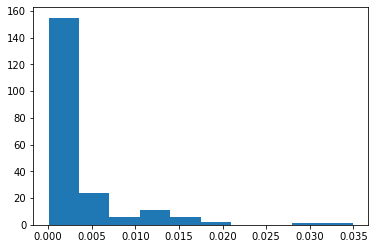

In [4]:
plt.hist(train_targets.mean())
#fonction d'assistance pour tracer la distribution des données d'expression génique et de viabilité cellulaire

In [5]:
#list afin de tracer des countplots pour le nombre des entités catégorielles 
catList = ['cp_type', 'cp_dose']
countList =  list (set(train_features.columns) - set(catList))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


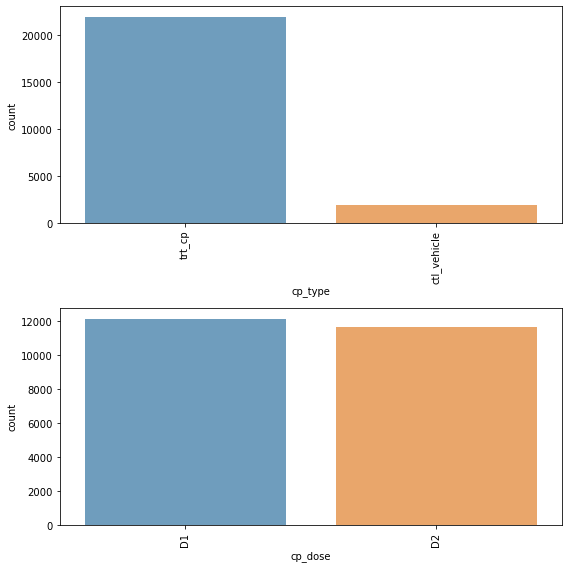

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for i, ax in enumerate(fig.axes):
    if i < len(catList):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=catList[i], alpha=0.7, data=train_features, ax=ax)

fig.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


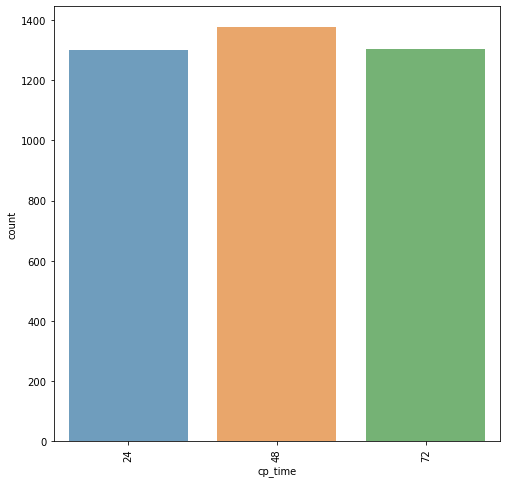

In [7]:

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

for i, ax in enumerate(fig.axes):

    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)

    sns.countplot(x='cp_time', alpha=0.7, data=test_features, ax=ax)

In [8]:
#Analyse de l'importance des fonctionnalités en fonction de la cible (target_scored)
train_targets.mean()[train_targets.mean() == train_targets.mean().max()]

nfkb_inhibitor    0.034937
dtype: float64

In [9]:
# fonction qui renvoie des statistiques de valeur  triées 
#des colonnes d'expression génique (g-) et des colonnes de viabilité cellulaire (c-)
def getContinuousVariablesRanking(df, target):
    cont_vars = [i for i in list(df.dtypes[df.dtypes != 'object'].index) if i != target]

    Fvalue_selector = SelectKBest(f_classif, k=len(cont_vars))
    Fvalue_selector.fit_transform(df[cont_vars].fillna(-1), df[target])
    df_Fvalue = pd.DataFrame(Fvalue_selector.scores_,
                             columns=['scaled_importance'])
    # scaling the statistics
    df_Fvalue -= df_Fvalue.min()
    df_Fvalue /= df_Fvalue.max()
    df_Fvalue['columns'] = cont_vars
    df_Fvalue.sort_values(by='scaled_importance', ascending=False, inplace=True)
    
    return df_Fvalue

In [10]:
features_toptarget_count = pd.concat([train_features[countList], train_targets['nfkb_inhibitor'].astype('str')], axis = 1)

df_value = getContinuousVariablesRanking(features_toptarget_count, 'nfkb_inhibitor')

df_value

,scaled_importance,columns
302,1.000000e+00,c-78
640,9.153353e-01,c-32
427,8.937890e-01,c-53
871,8.923579e-01,c-31
336,8.381294e-01,c-16
...,...,...
497,1.583474e-06,g-127
648,1.144620e-06,g-193
31,4.456896e-07,g-510
801,2.709965e-07,g-606


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

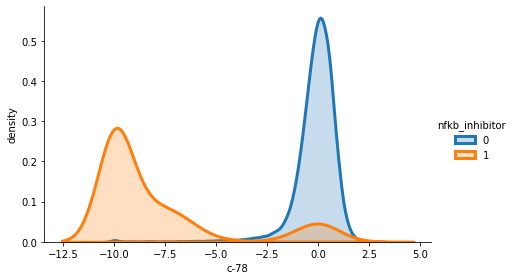

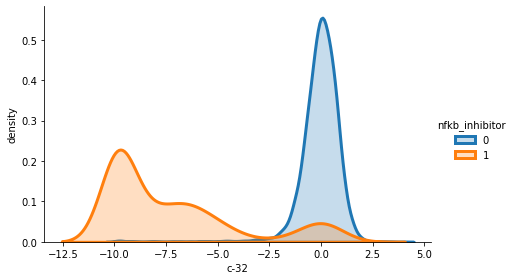

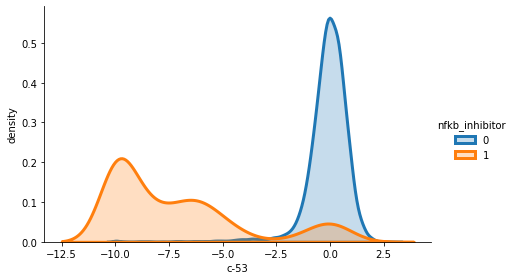

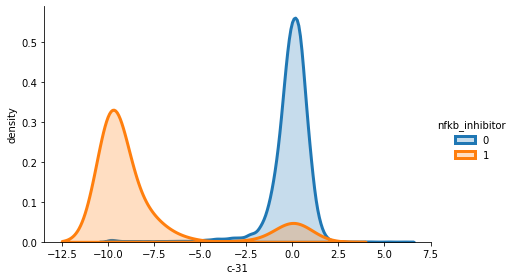

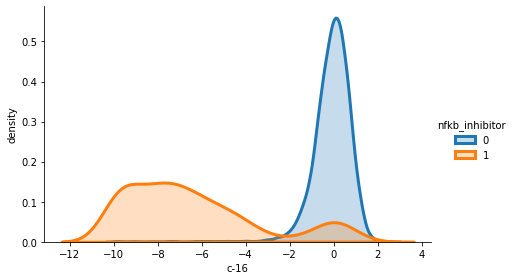

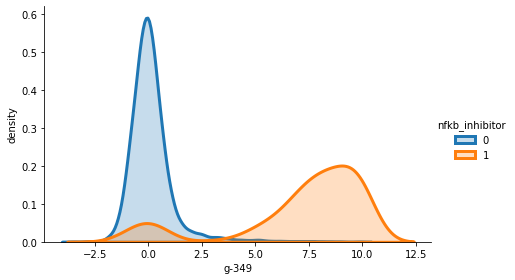

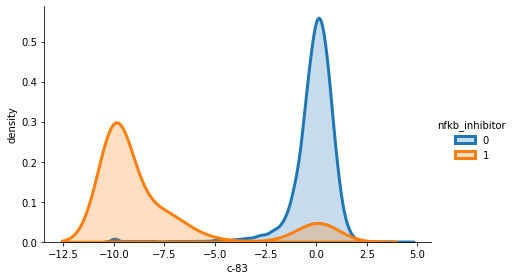

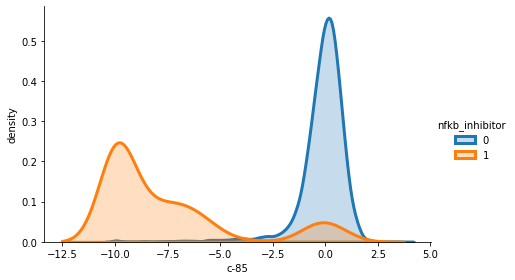

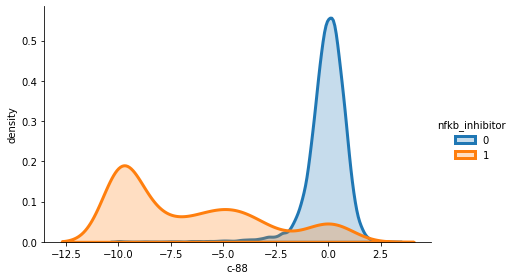

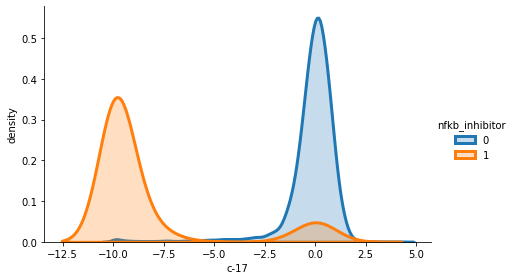

In [11]:
colist = df_value.head(10)['columns']
label = 'nfkb_inhibitor'
for col in colist: 
    
    g = sns.FacetGrid(features_toptarget_count[[col, label]],  hue =label, height = 4, aspect = 1.5) 
    g.map(sns.distplot, col, hist = False, kde_kws = {'shade': True, 'linewidth': 3}).set_axis_labels(col,"density").add_legend()

In [12]:
# séparation des colonnes (g-) et de  (c-)
gene_cols = [col for col in train_features.columns if col.startswith('g-')]
cell_cols = [col for col in train_features.columns if col.startswith('c-')]

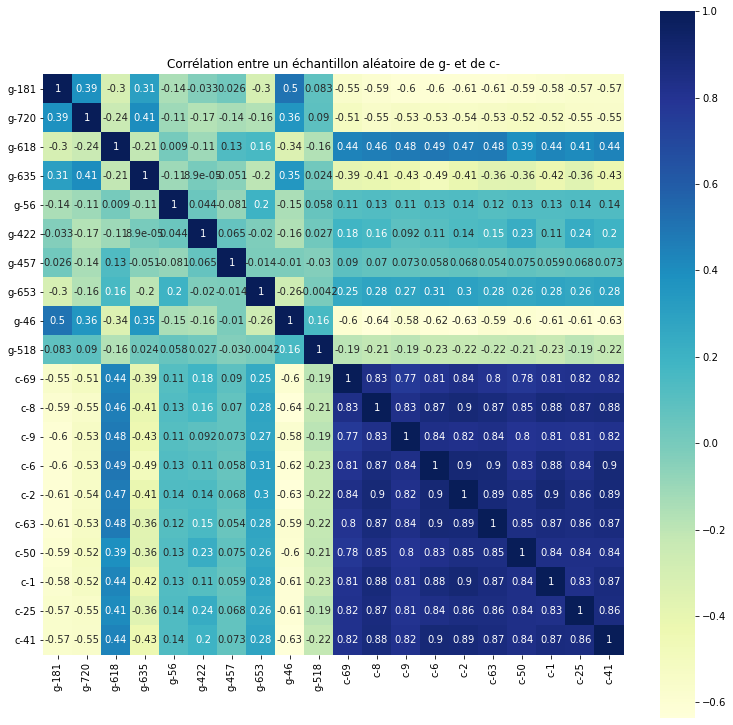

In [13]:
# une matrice de corrélation pour des entités sélectionnées au hasard
selected_cols = random.sample(gene_cols, 10) + random.sample(cell_cols, 10)
corr_selected_cols = train_features[selected_cols].corr()
plt.figure(figsize = (13,13))
sns.heatmap(corr_selected_cols, cmap="YlGnBu", annot = True, square = True)
plt.title('Corrélation entre un échantillon aléatoire de g- et de c-');

In [14]:
train_targets.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#la somme par colonne de toutes les cibles (nombre de réponses positives pour chaque cible)
x = train_targets.sum().sort_values().reset_index()
x.columns = ['target','responses']
x

,target,responses
0,atp-sensitive_potassium_channel_antagonist,1
1,erbb2_inhibitor,1
2,diuretic,6
3,autotaxin_inhibitor,6
4,protein_phosphatase_inhibitor,6
...,...,...
201,serotonin_receptor_antagonist,404
202,dopamine_receptor_antagonist,424
203,cyclooxygenase_inhibitor,435
204,proteasome_inhibitor,726


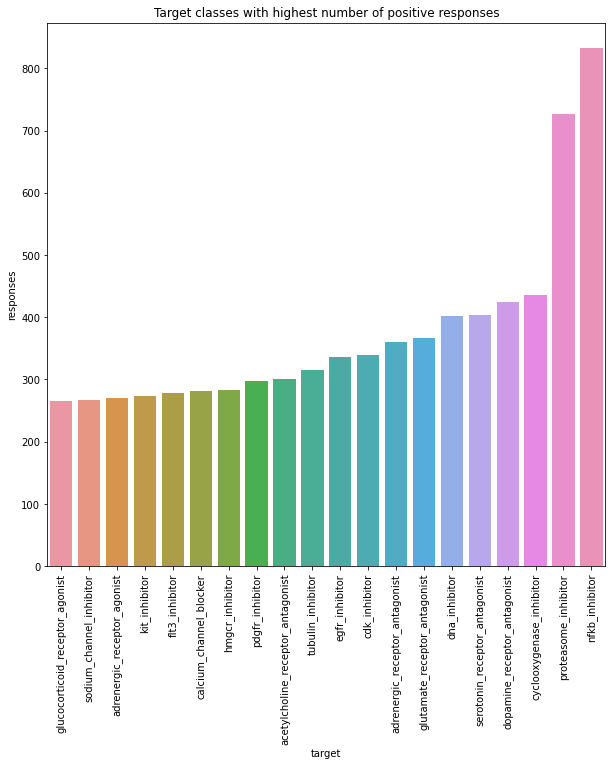

In [16]:
# tracer des classes cibles avec le plus grand nombre de réponses positives
fig = plt.figure(figsize = (10,10))
plt.title('Target classes with highest number of positive responses')
ax = sns.barplot(x = 'target', y = 'responses', data = x.tail(20))
ax.set_xticklabels(x.tail(20).target, rotation = 90);

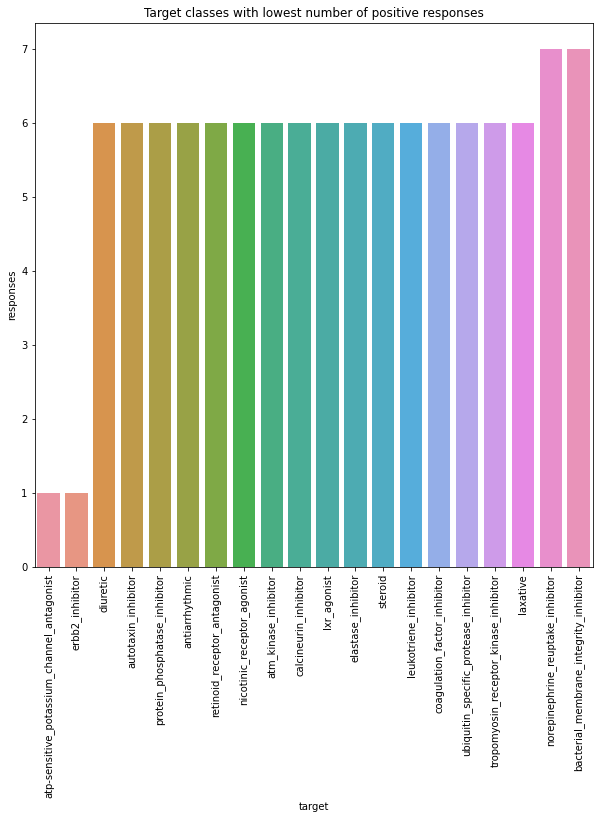

In [17]:
# tracer des classes cibles avec le plus petit nombre de réponses positives
fig = plt.figure(figsize = (10,10))
plt.title('Target classes with lowest number of positive responses')
ax = sns.barplot(x = 'target', y = 'responses', data = x.head(20))
ax.set_xticklabels(x.head(20).target, rotation = 90);

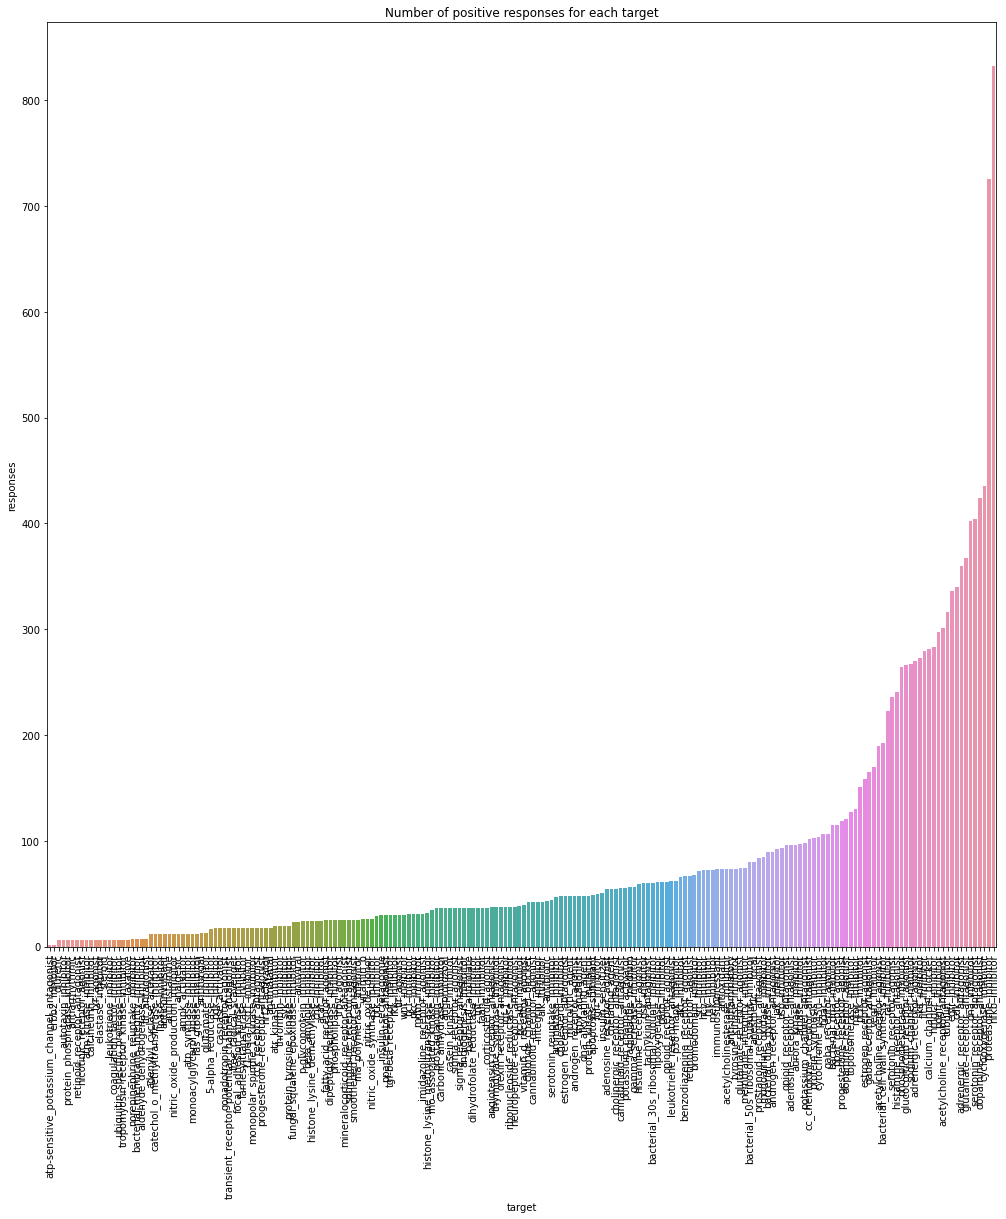

In [18]:
# tracer du nombre de réponses positives pour chaque classe cible
fig = plt.figure(figsize = (17,17))
plt.title('Number of positive responses for each target')
ax = sns.barplot(x = 'target', y = 'responses', data = x)
ax.set_xticklabels(x.target, rotation = 90);

In [19]:
# la somme par ligne de tous les sig_id (nombre d'activations par sig_id)
y = train_targets.sum(axis = 1)
y.value_counts()

1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


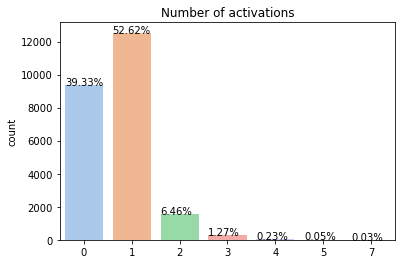

In [20]:
ax = sns.countplot(y, palette = 'pastel')
plt.title('Number of activations');
total = len(y)
for p in ax.patches:
    ht = p.get_height()
    ax.text(p.get_x(), ht, '{:1.2f}%'.format(ht*100/total))

# training avec le modèle de réseau neuronal simple

preparation des données

In [21]:
# transformation de données train_features 
#colonne cp_dose en une valeur numérique
train_features['cp_dose'] = train_features['cp_dose'].map({'D1':'0',"D2":'1'})
#cp_type column into a numeric value
s= []
for i in range(23814):
    if train_features['cp_type'][i] == "trt_cp":
        s.append(0)
    else :
        s.append(1)
train_features['cp_type']=s

In [22]:
# transformation de données test_features 
#colonne cp_dose en une valeur numérique
test_features['cp_dose'] = test_features['cp_dose'].map({'D1':'0',"D2":'1'})
#cp_type column into a numeric value
k= []
for i in range(3982):
    if test_features['cp_type'][i] == "trt_cp":
        k.append(0)
    else :
        k.append(1)
test_features['cp_type']=k

In [23]:
test_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,24,0,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,0,72,0,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,1,24,0,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,0,24,1,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,0,48,0,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [24]:
train_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,0,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,0,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,0,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,0,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,0,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [25]:
train = train_features.columns.tolist()
target = train_targets.columns.tolist()

In [26]:
train_feature = train_features.T.fillna(train_features.mean(axis=0)).T
train_feature
X_train = np.asarray(train_feature[train].values,dtype ='float32')
y_train = np.asarray(train_targets[target].values,dtype='float32')

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation,Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop

**le training**

In [28]:
def model_network():
    X_input = Input(shape = (875,))
    X = BatchNormalization()(X_input)
    X = Dense(units=2048, kernel_initializer = 'he_uniform')(X)
    X = tf.keras.layers.LeakyReLU(alpha=0.2)(X)
    X = BatchNormalization()(X)
    X = Dense(units =1024,kernel_initializer = 'he_uniform')(X)
    X = tf.keras.layers.LeakyReLU(alpha=0.2)(X)
    X = Dense(units =512,kernel_initializer = 'glorot_uniform')(X)
    X = Activation('tanh')(X)
    X =Dropout(0.2)(X)
    X_output = Dense(206,activation = 'sigmoid')(X)
    model = Model(inputs = X_input,outputs = X_output)
    return model
from functools import partial
RegularizedDense = partial(tf.keras.layers.Dense,activation = 'relu',kernel_initializer = 'he_normal',kernel_regularizer = tf.keras.regularizers.l2(0.0001))
def model2_network():
    X_input = X_input = Input(shape = (875,))
    X = BatchNormalization()(X_input)
    X = RegularizedDense(1024)(X)
    X = RegularizedDense(1024)(X)
    X =Dropout(0.2)(X)
    X_output = Dense(206,activation = 'sigmoid')(X)
    model = Model(inputs = X_input,outputs = X_output)
    return model

In [29]:
model = model_network()
model.compile(optimizer = RMSprop(0.0001), loss = BinaryCrossentropy())

In [30]:
model_final = model2_network()
model_final.compile(optimizer = Adam(), loss = BinaryCrossentropy())
model.fit(X_train,y_train,batch_size =256, epochs=15)
X_test = np.asarray(test_features[train].values, dtype = 'float32')
predictions = model.predict(X_test)

Epoch 1/15
94/94 [==============================] - 9s 83ms/step - loss: 0.2851
Epoch 2/15
94/94 [==============================] - 8s 82ms/step - loss: 0.0227
Epoch 3/15
94/94 [==============================] - 8s 84ms/step - loss: 0.0188
Epoch 4/15
94/94 [==============================] - 8s 85ms/step - loss: 0.0173
Epoch 5/15
94/94 [==============================] - 7s 80ms/step - loss: 0.0168
Epoch 6/15
94/94 [==============================] - 8s 82ms/step - loss: 0.0155
Epoch 7/15
94/94 [==============================] - 8s 82ms/step - loss: 0.0148
Epoch 8/15
94/94 [==============================] - 8s 86ms/step - loss: 0.0141
Epoch 9/15
94/94 [==============================] - 8s 84ms/step - loss: 0.0135
Epoch 10/15
94/94 [==============================] - 8s 82ms/step - loss: 0.0126
Epoch 11/15
94/94 [==============================] - 8s 80ms/step - loss: 0.0120
Epoch 12/15
94/94 [==============================] - 8s 87ms/step - loss: 0.0113
Epoch 13/15
94/94 [==================

In [31]:
predictions

array([[5.9571862e-04, 2.1878183e-03, 1.2258291e-03, ..., 1.9404292e-03,
        5.5808425e-03, 1.9261241e-03],
       [1.2021224e-04, 4.3874979e-04, 4.5439601e-04, ..., 6.9299340e-04,
        1.4151335e-03, 8.9284778e-04],
       [5.0471363e-06, 3.2163007e-06, 2.5672009e-05, ..., 2.4835674e-05,
        2.1384201e-05, 5.0893705e-06],
       ...,
       [1.8728673e-03, 4.1195750e-04, 3.9246678e-04, ..., 6.3791871e-04,
        4.0879846e-04, 1.1366904e-03],
       [5.7488680e-04, 3.4064054e-04, 5.5271387e-04, ..., 4.1511655e-04,
        3.2311678e-04, 2.0973980e-03],
       [1.1466969e-04, 2.0220876e-04, 3.3685565e-04, ..., 3.9339066e-04,
        4.4533610e-04, 2.2169948e-04]], dtype=float32)

In [32]:
data = pd.DataFrame.from_records(predictions)
data.columns = train_targets.columns
data.insert(0,'sig_id',sig_id)
data.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0.000596,0.002188,0.001226,0.017551,0.005875,0.000638,0.000371,0.002330,0.000117,...,0.000084,0.000418,0.003427,0.001346,0.000433,7.771766e-05,0.000419,0.001940,0.005581,0.001926
1,id_000779bfc,0.000120,0.000439,0.000454,0.002194,0.003875,0.002535,0.001855,0.018506,0.002135,...,0.000054,0.001075,0.000809,0.000427,0.005418,3.163218e-04,0.001866,0.000693,0.001415,0.000893
2,id_000a6266a,0.000005,0.000003,0.000026,0.000135,0.000728,0.000015,0.000068,0.000059,0.000003,...,0.000002,0.000024,0.000075,0.000196,0.000021,2.220984e-07,0.000044,0.000025,0.000021,0.000005
3,id_0015fd391,0.000289,0.000252,0.005768,0.004898,0.002168,0.005904,0.000975,0.002576,0.000446,...,0.000260,0.000861,0.008050,0.013922,0.002251,1.875460e-04,0.002520,0.001183,0.000318,0.001084
4,id_001626bd3,0.001386,0.002046,0.001940,0.006233,0.003835,0.001586,0.004961,0.000806,0.000168,...,0.000309,0.000615,0.003039,0.001278,0.000199,3.729165e-04,0.002125,0.001209,0.000457,0.002875


In [33]:
data.to_csv('submission.csv', index=False)